# Define some paths

In [3]:
base_path = '/home/ec2-user/'
s3_base_path = base_path + 's3/'
s3_data_path = s3_base_path + 'data/'
s3_results_path = s3_base_path + 'results/'

s3_bucket_name = 'borowis-s3-us-east-1'

In [4]:
data_path = base_path + 'data/'
train_path = data_path + 'train/'
test_path = data_path + 'test/'
valid_path = data_path + 'valid/'
sample_path = data_path + 'sample/'

In [5]:
categories = ['c' + str(i) for i in range(10)]

# Imports

In [1]:
from utils import *
from vgg16 import Vgg16

%matplotlib inline

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/usr/local/lib/python2.7/site-packages/Theano-0.8.2-py2.7.egg/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


# Common functions

In [2]:
def plots_idx(base_path, idx, titles=None):
    plots([image.load_img(base_path + filenames[i]) for i in idx], titles=titles)

In [10]:
def onehot(x): return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())

# Command to sync with aws s3 bucket

In [90]:
!aws s3 sync $s3_base_path $s3_bucket_name


usage: aws [options] <command> <subcommand> [parameters]
aws: error: too few arguments


# Unzip data

In [63]:
!mkdir $data_path
!unzip -q $s3_data_path/statefarm.zip -d $data_path

file #1:  bad zipfile offset (local header sig):  0
file #2:  bad zipfile offset (local header sig):  35
file #3:  bad zipfile offset (local header sig):  41477


# Create sample/validation sets from statefarm data

Dataset size:

In [64]:
!ls -al $data_path/test/ | wc -l
for c in categories:
    !echo "$c: `ls -al $data_path/train/$c | wc -l`"

79727
c0: 2492
c1: 2270
c2: 2320
c3: 2349
c4: 2329
c5: 2315
c6: 2328
c7: 2005
c8: 1914
c9: 2132


We have test / train set, now we need a validaton set and sample set

In [65]:
!mkdir $valid_path
for c in categories:
    !mkdir $valid_path/$c

!ls -al $valid_path

total 48
drwxrwxr-x 12 ec2-user ec2-user 4096 May  4 21:17 .
drwxrwxr-x  5 ec2-user ec2-user 4096 May  4 21:17 ..
drwxrwxr-x  2 ec2-user ec2-user 4096 May  4 21:17 c0
drwxrwxr-x  2 ec2-user ec2-user 4096 May  4 21:17 c1
drwxrwxr-x  2 ec2-user ec2-user 4096 May  4 21:17 c2
drwxrwxr-x  2 ec2-user ec2-user 4096 May  4 21:17 c3
drwxrwxr-x  2 ec2-user ec2-user 4096 May  4 21:17 c4
drwxrwxr-x  2 ec2-user ec2-user 4096 May  4 21:17 c5
drwxrwxr-x  2 ec2-user ec2-user 4096 May  4 21:17 c6
drwxrwxr-x  2 ec2-user ec2-user 4096 May  4 21:17 c7
drwxrwxr-x  2 ec2-user ec2-user 4096 May  4 21:17 c8
drwxrwxr-x  2 ec2-user ec2-user 4096 May  4 21:17 c9


In [66]:
!mkdir $sample_path
!mkdir $sample_path/train
!mkdir $sample_path/valid

for c in categories:
    !mkdir $sample_path/train/$c
    !mkdir $sample_path/valid/$c

In [67]:
!ls -al $sample_path/train

total 48
drwxrwxr-x 12 ec2-user ec2-user 4096 May  4 21:17 .
drwxrwxr-x  4 ec2-user ec2-user 4096 May  4 21:17 ..
drwxrwxr-x  2 ec2-user ec2-user 4096 May  4 21:17 c0
drwxrwxr-x  2 ec2-user ec2-user 4096 May  4 21:17 c1
drwxrwxr-x  2 ec2-user ec2-user 4096 May  4 21:17 c2
drwxrwxr-x  2 ec2-user ec2-user 4096 May  4 21:17 c3
drwxrwxr-x  2 ec2-user ec2-user 4096 May  4 21:17 c4
drwxrwxr-x  2 ec2-user ec2-user 4096 May  4 21:17 c5
drwxrwxr-x  2 ec2-user ec2-user 4096 May  4 21:17 c6
drwxrwxr-x  2 ec2-user ec2-user 4096 May  4 21:17 c7
drwxrwxr-x  2 ec2-user ec2-user 4096 May  4 21:17 c8
drwxrwxr-x  2 ec2-user ec2-user 4096 May  4 21:17 c9


In [68]:
!ls -al $sample_path/valid

total 48
drwxrwxr-x 12 ec2-user ec2-user 4096 May  4 21:17 .
drwxrwxr-x  4 ec2-user ec2-user 4096 May  4 21:17 ..
drwxrwxr-x  2 ec2-user ec2-user 4096 May  4 21:17 c0
drwxrwxr-x  2 ec2-user ec2-user 4096 May  4 21:17 c1
drwxrwxr-x  2 ec2-user ec2-user 4096 May  4 21:17 c2
drwxrwxr-x  2 ec2-user ec2-user 4096 May  4 21:17 c3
drwxrwxr-x  2 ec2-user ec2-user 4096 May  4 21:17 c4
drwxrwxr-x  2 ec2-user ec2-user 4096 May  4 21:17 c5
drwxrwxr-x  2 ec2-user ec2-user 4096 May  4 21:17 c6
drwxrwxr-x  2 ec2-user ec2-user 4096 May  4 21:17 c7
drwxrwxr-x  2 ec2-user ec2-user 4096 May  4 21:17 c8
drwxrwxr-x  2 ec2-user ec2-user 4096 May  4 21:17 c9


In [69]:
import random
import os
import shutil

def sample(base_path, destination_path, categories, sample_size, should_copy=True):
    func = shutil.copy if should_copy else shutil.move
    
    for category in categories:
        category_imgs = os.listdir(base_path + category)
        for category_img in random.sample(category_imgs, sample_size):
            func(base_path + category + '/' + category_img, destination_path + category)

In [70]:
SAMPLE_TRAIN_SIZE = 100
SAMPLE_VALID_SIZE = 25

sample(train_path, sample_path + 'train/', categories, SAMPLE_TRAIN_SIZE)
sample(train_path, sample_path + 'valid/', categories, SAMPLE_VALID_SIZE)

In [71]:
VALID_SIZE = 450

sample(train_path, valid_path, categories, VALID_SIZE, should_copy=False)

Prepare test set

In [72]:
!mkdir $test_path/unknown
!find $test_path -type f -iname '*.jpg' | xargs mv -t $test_path/unknown/

mv: ‘/home/ec2-user/data/test/unknown/img_33694.jpg’ and ‘/home/ec2-user/data/test//unknown/img_33694.jpg’ are the same file
mv: ‘/home/ec2-user/data/test/unknown/img_11806.jpg’ and ‘/home/ec2-user/data/test//unknown/img_11806.jpg’ are the same file
mv: ‘/home/ec2-user/data/test/unknown/img_69387.jpg’ and ‘/home/ec2-user/data/test//unknown/img_69387.jpg’ are the same file
mv: ‘/home/ec2-user/data/test/unknown/img_30820.jpg’ and ‘/home/ec2-user/data/test//unknown/img_30820.jpg’ are the same file
mv: ‘/home/ec2-user/data/test/unknown/img_3613.jpg’ and ‘/home/ec2-user/data/test//unknown/img_3613.jpg’ are the same file
mv: ‘/home/ec2-user/data/test/unknown/img_20854.jpg’ and ‘/home/ec2-user/data/test//unknown/img_20854.jpg’ are the same file
mv: ‘/home/ec2-user/data/test/unknown/img_96679.jpg’ and ‘/home/ec2-user/data/test//unknown/img_96679.jpg’ are the same file
mv: ‘/home/ec2-user/data/test/unknown/img_62028.jpg’ and ‘/home/ec2-user/data/test//unknown/img_62028.jpg’ are the same file
mv

In [77]:
!ls -al $test_path/unknown | wc -l

79727


In [82]:
!echo $data_path

/home/ec2-user/data/
/home/ec2-user/fast.ai/deeplearning1/nbs


In [89]:
!tar -cf $base_path/statefarm.tar -C $data_path sample/ test/ train/ valid/

# If you already have data

In [4]:
!mkdir $data_path
!tar -xf $s3_data_path/statefarm.tar -C $data_path

# Check directory structure

In [5]:
for c in categories:
    !echo "$c: `ls -al $train_path/$c | wc -l`"

c0: 2042
c1: 1820
c2: 1870
c3: 1899
c4: 1879
c5: 1865
c6: 1878
c7: 1555
c8: 1464
c9: 1682


In [6]:
for c in categories:
    !echo "$c: `ls -al $sample_path/valid/$c | wc -l`"

c0: 28
c1: 28
c2: 28
c3: 28
c4: 28
c5: 28
c6: 28
c7: 28
c8: 28
c9: 28


# Data exploration

In [29]:
n_view = 3
batch_size = 64
sample_val_batches = get_batches(sample_path + 'valid', shuffle=False, batch_size=1)
sample_batches = get_batches(sample_path + 'train', shuffle=False, batch_size=1)

Found 250 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


In [11]:
sample_val_classes = sample_val_batches.classes
sample_trn_classes = sample_batches.classes

sample_val_labels = onehot(sample_val_classes)
sample_trn_labels = onehot(sample_trn_classes)

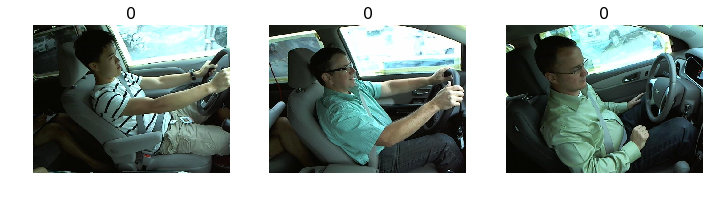

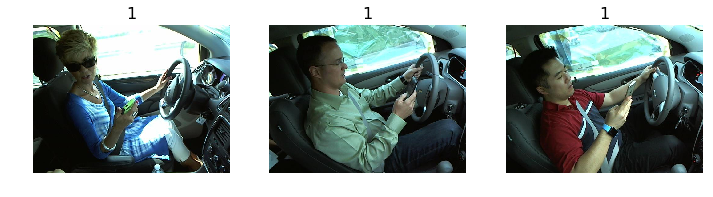

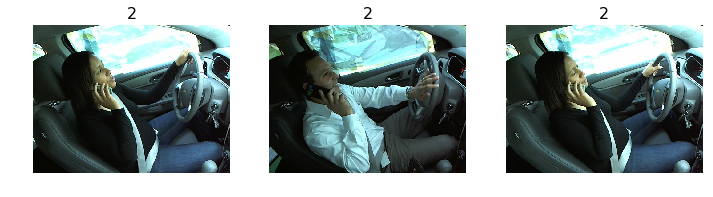

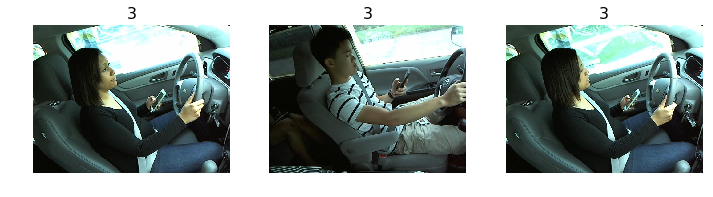

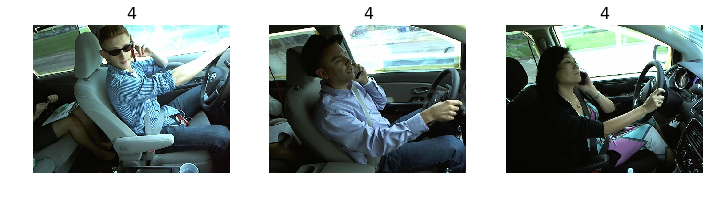

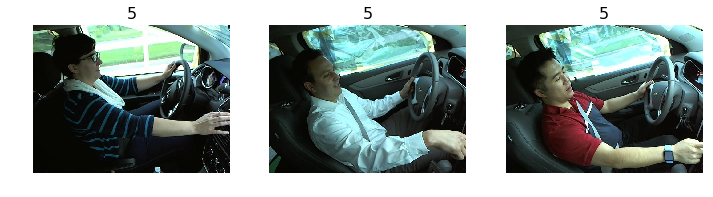

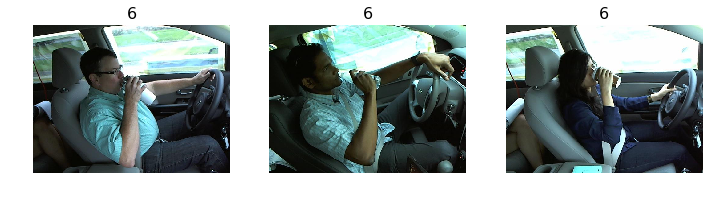

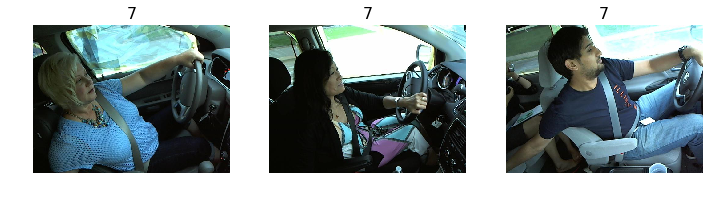

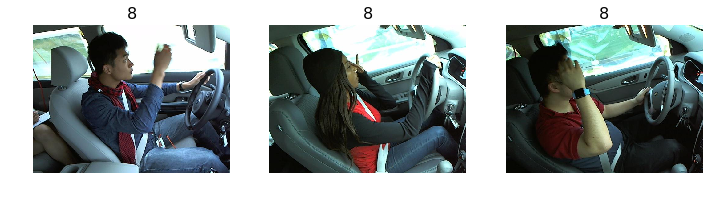

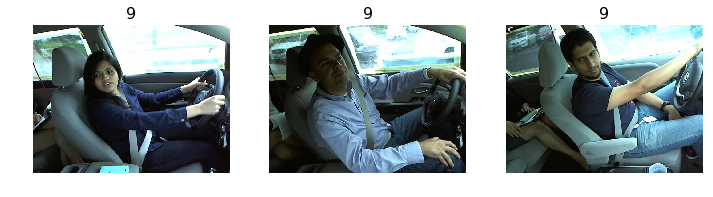

In [34]:
filenames = sample_val_batches.filenames
for i in range(len(categories)):
    plots_idx(sample_path + 'valid/', permutation(np.where(sample_val_classes == i)[0])[:n_view], [i] * n_view)

# Training on sample

In [37]:
vgg = Vgg16()

Exception: URL fetch failure on http://www.platform.ai/models/vgg16.h5: None -- [Errno -2] Name or service not known

In [ ]:
lm.fit(sample_trn_features, sample_trn_labels, nb_epoch=3, batch_size=batch_size, 
       validation_data=(sample_val_features, sample_val_labels))